In [24]:
import pandas as pd
landmarks_df = pd.read_csv('/Users/suryanshpatel/Projects/Directed Readings/Technical/src/data/landmarks_sequences.csv')
landmarks_df = landmarks_df.dropna()
landmarks_df.head()

,Subject,Trial,Start_Timestamp,End_Timestamp,Label,Landmark_Sequence
0,1,1,11-51-02-0121,11-51-02-3452,0,[[ 0.53017837 0.39306363 -0.47699088 ... 1.5...
1,1,1,11-51-02-0782,11-51-02-3779,0,[[ 0.52858424 0.38866973 -0.49497882 ... 1.5...
2,1,1,11-51-02-1118,11-51-02-4121,0,[[ 0.53160912 0.39035293 -0.51969194 ... 1.5...
3,1,1,11-51-02-1451,11-51-02-4451,0,[[ 0.5293504 0.39020142 -0.46587169 ... 1.5...
4,1,1,11-51-02-2123,11-51-02-4781,0,[[ 0.5324769 0.39163902 -0.52662343 ... 1.5...


In [25]:
import numpy as np

# Assuming your DataFrame is landmarks_df
X = np.stack(landmarks_df['Landmark_Sequence'].values)  # shape (54000, 8, 132)
y = landmarks_df['Label'].values                        # shape (54000,)

In [26]:
import numpy as np

X = np.array([np.fromstring(x.strip('[]'), sep=' ') for x in X])


/var/folders/r2/_zqwhs3s7zd_mvl3kt6zzfsr0000gn/T/ipykernel_2030/2534005685.py:3: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  X = np.array([np.fromstring(x.strip('[]'), sep=' ') for x in X])


In [27]:
X_mean = X.mean()
X_std = X.std()
X = (X - X_mean) / (X_std + 1e-6)


In [6]:
X

array([[ 0.76222077,  0.48884564, -1.24584214],
       [ 0.75904245,  0.48008522, -1.28170593],
       [ 0.76507336,  0.48344113, -1.33097819],
       ...,
       [ 0.85178794,  0.77940188, -1.40394098],
       [ 0.85632779,  0.78104707, -1.39364142],
       [ 0.85295945,  0.78982753, -1.49261972]])

In [5]:
X.shape, y.shape

((54105, 3), (54105,))

(3,)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [28]:
import torch
from torch.utils.data import Dataset, DataLoader

class PainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = PainDataset(X_train, y_train)
val_dataset = PainDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [29]:
import torch.nn as nn

class PainClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(PainClassifier, self).__init__()
        self.cnn = nn.Sequential(
            # nn.Conv1d(132, 256, kernel_size=3, padding=1),
            nn.Conv1d(3, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(128, 64, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # last timestep
        x = self.fc(x)
        return x


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PainClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        if X_batch.dim() == 2:
            X_batch = X_batch.unsqueeze(1)  # Add a channel dimension
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            if X_batch.dim() == 2:
                X_batch = X_batch.unsqueeze(1)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {correct/total:.4f}")


Epoch 1, Train Loss: 1.3937, Val Loss: 1.3917, Val Acc: 0.4977
Epoch 2, Train Loss: 1.3909, Val Loss: 1.3906, Val Acc: 0.4977


In [29]:
val_loader.dataset.X.shape, val_loader.dataset.y.shape

(torch.Size([10821, 3]), torch.Size([10821]))

Epoch 1, Train Loss: 1.6114, Val Loss: 1.6041, Val Acc: 27.5000%
Epoch 2, Train Loss: 1.6093, Val Loss: 1.6076, Val Acc: 20.5000%
Epoch 3, Train Loss: 1.6075, Val Loss: 1.6097, Val Acc: 18.0000%
Epoch 4, Train Loss: 1.6076, Val Loss: 1.6138, Val Acc: 16.0000%
Epoch 5, Train Loss: 1.6059, Val Loss: 1.6146, Val Acc: 15.5000%
Epoch 6, Train Loss: 1.6056, Val Loss: 1.6152, Val Acc: 17.0000%
Epoch 7, Train Loss: 1.6043, Val Loss: 1.6163, Val Acc: 19.5000%
Epoch 8, Train Loss: 1.6038, Val Loss: 1.6193, Val Acc: 18.5000%
Epoch 9, Train Loss: 1.6037, Val Loss: 1.6226, Val Acc: 16.0000%
Epoch 10, Train Loss: 1.6011, Val Loss: 1.6224, Val Acc: 18.0000%
Epoch 11, Train Loss: 1.5996, Val Loss: 1.6261, Val Acc: 18.0000%
Epoch 12, Train Loss: 1.5986, Val Loss: 1.6302, Val Acc: 17.5000%
Epoch 13, Train Loss: 1.5941, Val Loss: 1.6301, Val Acc: 19.0000%
Epoch 14, Train Loss: 1.5943, Val Loss: 1.6348, Val Acc: 19.0000%
Epoch 15, Train Loss: 1.5891, Val Loss: 1.6368, Val Acc: 21.0000%
Epoch 16, Train Los

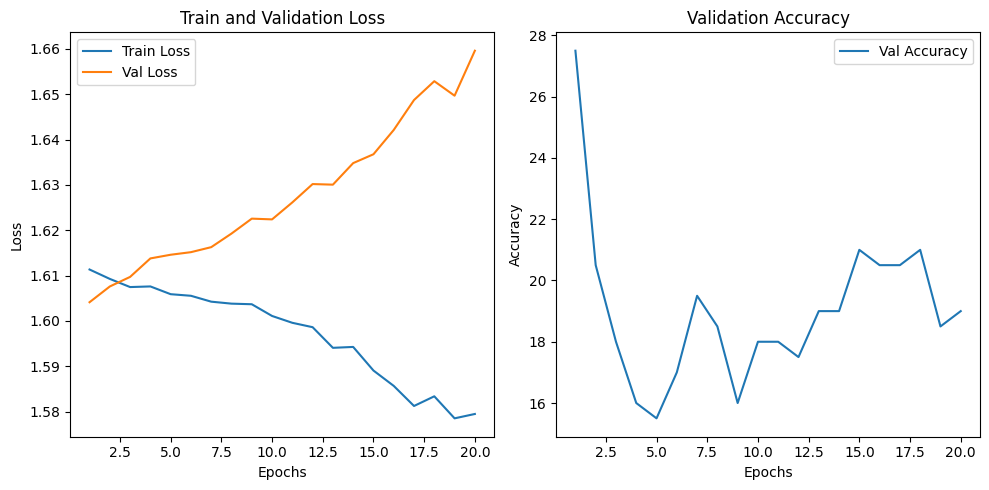

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have your dataset and dataloaders

# Define the model
class PainClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(PainClassifier, self).__init__()
        
        # CNN Layer (e.g., for feature extraction)
        self.cnn = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)  # in_channels=3 (features per frame)
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, batch_first=True, dropout=0.2)
        
        # Fully connected layer to output class probabilities
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x.shape should be [batch_size, seq_len=8, num_features=3]
        x = x.permute(0, 2, 1)  # Reshape to [batch_size, features, seq_len] for CNN
        x = self.cnn(x)         # Apply CNN to extract features
        x = x.permute(0, 2, 1)  # Reshape back for LSTM
        x, _ = self.lstm(x)     # Apply LSTM to capture temporal dependencies
        x = x[:, -1, :]         # Use the last hidden state for classification
        x = self.fc(x)          # Fully connected layer for classification
        return x

# Dataset class (assuming you have already preprocessed your data)
class PainDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # Features
        self.y = y  # Labels
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

# Example data (replace with your actual dataset)
X_train = np.random.randn(1000, 8, 3)  # 1000 samples, 8 frames, 3 features per frame
y_train = np.random.randint(0, 5, 1000)  # Random labels (0-4 for 5 classes)

X_val = np.random.randn(200, 8, 3)
y_val = np.random.randint(0, 5, 200)

# Create Dataset and DataLoader
train_dataset = PainDataset(X_train, y_train)
val_dataset = PainDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PainClassifier(num_classes=5).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Train loop
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_losses.append(avg_train_loss)

    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    # Validation loop
    with torch.no_grad():  # No need to compute gradients during validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val * 100
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}%")

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming you have already loaded and preprocessed your data into X_train, X_val, y_train, y_val

# Normalize input features (if necessary)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the model
class PainClassifier(nn.Module):
    def __init__(self, input_size=3):
        super(PainClassifier, self).__init__()
        
        # LSTM layer with Dropout
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=128, num_layers=2, batch_first=True, dropout=0.5)
        
        # Fully connected layer
        self.fc = nn.Linear(128, 5)  # 5 classes (0 to 4)

    def forward(self, x):
        # LSTM expects input in the shape (batch_size, seq_len, input_size)
        x, _ = self.lstm(x)
        
        # Take the last output of the LSTM
        x = x[:, -1, :]
        
        # Fully connected layer to output class scores
        x = self.fc(x)
        
        return x

# Instantiate the model, loss function, and optimizer
model = PainClassifier(input_size=3)  # Set input_size based on your data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Compute class weights based on the frequency of each class
y_train_np = y_train.numpy()  # Convert to numpy array for class weight computation
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1, 2, 3, 4]), y=y_train_np)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, num_classes=5):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, reduction='none')

    def forward(self, inputs, targets):
        log_pt = self.ce_loss(inputs, targets)
        pt = torch.exp(-log_pt)
        loss = self.alpha * (1 - pt) ** self.gamma * log_pt
        return loss.mean()

criterion = FocalLoss(alpha=1, gamma=2)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_batch)
        
        # Compute loss
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        # Update train metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    # Validation loop
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    # Compute accuracy
    train_acc = 100 * correct / total
    val_acc = 100 * correct_val / total_val
    
    # Print results
    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    
    # Update learning rate
    scheduler.step()


/var/folders/r2/_zqwhs3s7zd_mvl3kt6zzfsr0000gn/T/ipykernel_10408/162355337.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
/var/folders/r2/_zqwhs3s7zd_mvl3kt6zzfsr0000gn/T/ipykernel_10408/162355337.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.long)


Epoch 1, Train Loss: 1.0354, Val Loss: 1.0317, Train Acc: 21.00%, Val Acc: 21.50%
Epoch 2, Train Loss: 1.0317, Val Loss: 1.0321, Train Acc: 20.10%, Val Acc: 20.50%
Epoch 3, Train Loss: 1.0312, Val Loss: 1.0361, Train Acc: 21.20%, Val Acc: 23.50%
Epoch 4, Train Loss: 1.0297, Val Loss: 1.0392, Train Acc: 20.70%, Val Acc: 22.50%
Epoch 5, Train Loss: 1.0271, Val Loss: 1.0374, Train Acc: 20.40%, Val Acc: 17.00%
Epoch 6, Train Loss: 1.0218, Val Loss: 1.0382, Train Acc: 21.80%, Val Acc: 16.50%
Epoch 7, Train Loss: 1.0210, Val Loss: 1.0398, Train Acc: 23.50%, Val Acc: 19.50%
Epoch 8, Train Loss: 1.0203, Val Loss: 1.0405, Train Acc: 23.10%, Val Acc: 20.50%
Epoch 9, Train Loss: 1.0188, Val Loss: 1.0421, Train Acc: 24.20%, Val Acc: 21.50%
Epoch 10, Train Loss: 1.0183, Val Loss: 1.0434, Train Acc: 23.80%, Val Acc: 23.50%
Epoch 11, Train Loss: 1.0188, Val Loss: 1.0435, Train Acc: 24.50%, Val Acc: 24.00%
Epoch 12, Train Loss: 1.0171, Val Loss: 1.0436, Train Acc: 23.90%, Val Acc: 24.00%
Epoch 13, Tra

In [35]:
landmarks_df['Label'].value_counts()

Label
0    26927
4     6844
3     6825
1     6767
2     6742
Name: count, dtype: int64

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming you have already loaded and preprocessed your data into X_train, X_val, y_train, y_val

# Normalize input features (if necessary)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the GRU-based model
class GRUClassifier(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_classes=5):
        super(GRUClassifier, self).__init__()
        
        # Bidirectional GRU layer
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=2, 
                          batch_first=True, dropout=0.5, bidirectional=True)
        
        # Fully connected layer (output size will be 2 * hidden_size due to bidirectionality)
        self.fc = nn.Linear(2 * hidden_size, num_classes)
        
    def forward(self, x):
        # GRU expects input in the shape (batch_size, seq_len, input_size)
        x, _ = self.gru(x)
        
        # Take the last output of the GRU
        x = x[:, -1, :]  # (batch_size, 2 * hidden_size) because it's bidirectional
        
        # Fully connected layer
        x = self.fc(x)
        
        return x


# Instantiate the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUClassifier(input_size=3, hidden_size=128, num_classes=5).to(device)

# Compute class weights based on the frequency of each class
y_train_np = y_train.numpy()  # Convert to numpy array for class weight computation
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1, 2, 3, 4]), y=y_train_np)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use CrossEntropyLoss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_batch)
        
        # Compute loss
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        # Update train metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    # Validation loop
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    # Compute accuracy
    train_acc = 100 * correct / total
    val_acc = 100 * correct_val / total_val
    
    # Print results
    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    
    # Update learning rate
    scheduler.step()

# Save the trained model
torch.save(model.state_dict(), 'gru_classifier.pth')


/var/folders/r2/_zqwhs3s7zd_mvl3kt6zzfsr0000gn/T/ipykernel_10408/3794502508.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
/var/folders/r2/_zqwhs3s7zd_mvl3kt6zzfsr0000gn/T/ipykernel_10408/3794502508.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.long)


Epoch 1, Train Loss: 1.6184, Val Loss: 1.6052, Train Acc: 19.50%, Val Acc: 24.50%
Epoch 2, Train Loss: 1.6089, Val Loss: 1.6096, Train Acc: 21.40%, Val Acc: 22.00%
Epoch 3, Train Loss: 1.6046, Val Loss: 1.6182, Train Acc: 22.60%, Val Acc: 22.50%
Epoch 4, Train Loss: 1.6035, Val Loss: 1.6237, Train Acc: 22.50%, Val Acc: 18.00%
Epoch 5, Train Loss: 1.5982, Val Loss: 1.6337, Train Acc: 25.40%, Val Acc: 23.00%
Epoch 6, Train Loss: 1.5894, Val Loss: 1.6335, Train Acc: 25.40%, Val Acc: 21.50%
Epoch 7, Train Loss: 1.5915, Val Loss: 1.6354, Train Acc: 26.10%, Val Acc: 21.50%
Epoch 8, Train Loss: 1.5871, Val Loss: 1.6374, Train Acc: 27.10%, Val Acc: 20.50%
Epoch 9, Train Loss: 1.5888, Val Loss: 1.6381, Train Acc: 25.60%, Val Acc: 19.50%
Epoch 10, Train Loss: 1.5917, Val Loss: 1.6386, Train Acc: 26.50%, Val Acc: 21.00%
Epoch 11, Train Loss: 1.5862, Val Loss: 1.6387, Train Acc: 27.30%, Val Acc: 21.00%
Epoch 12, Train Loss: 1.5854, Val Loss: 1.6388, Train Acc: 26.40%, Val Acc: 21.00%
Epoch 13, Tra

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time

# Assuming X_data and y_data are the loaded and preprocessed data (X_data: features, y_data: labels)
# Example: X_data shape (num_samples, seq_len, num_features)
#          y_data shape (num_samples,)

# Data Preprocessing
scaler = StandardScaler()

# # Normalize input features (if necessary)
# X_data = scaler.fit_transform(X_data.reshape(-1, X_data.shape[2])).reshape(X_data.shape)

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the Bidirectional GRU model
class GRUClassifier(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_classes=5):
        super(GRUClassifier, self).__init__()
        
        # Bidirectional GRU layer
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=2, 
                          batch_first=True, dropout=0.5, bidirectional=True)
        
        # Fully connected layer (output size will be 2 * hidden_size due to bidirectionality)
        self.fc = nn.Linear(2 * hidden_size, num_classes)
        
    def forward(self, x):
        # GRU expects input in the shape (batch_size, seq_len, input_size)
        x, _ = self.gru(x)
        
        # Take the last output of the GRU
        x = x[:, -1, :]  # (batch_size, 2 * hidden_size) because it's bidirectional
        
        # Fully connected layer
        x = self.fc(x)
        
        return x

# Instantiate the model, loss function, and optimizer
model = GRUClassifier(input_size=3)  # Set input_size based on your data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Compute class weights based on the frequency of each class
y_train_np = y_train.numpy()  # Convert to numpy array for class weight computation
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, num_classes=5):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, reduction='none')

    def forward(self, inputs, targets):
        log_pt = self.ce_loss(inputs, targets)
        pt = torch.exp(-log_pt)
        loss = self.alpha * (1 - pt) ** self.gamma * log_pt
        return loss.mean()

criterion = FocalLoss(alpha=1, gamma=2)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early stopping setup
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_batch)
        
        # Compute loss
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        # Update train metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    # Validation loop
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    # Compute accuracy
    train_acc = 100 * correct / total
    val_acc = 100 * correct_val / total_val
    
    # Print results
    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Optionally, save the model here
        torch.save(model.state_dict(), '/Users/suryanshpatel/Projects/Directed Readings/Technical/src/Models/mediapipe_best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping due to no improvement in validation loss.")
        break
    
    # Update learning rate
    scheduler.step()

# Load best model if early stopping occurred
model.load_state_dict(torch.load('/Users/suryanshpatel/Projects/Directed Readings/Technical/src/Models/mediapipe_best_model.pth'))
model.eval()


/var/folders/r2/_zqwhs3s7zd_mvl3kt6zzfsr0000gn/T/ipykernel_10408/343469418.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/r2/_zqwhs3s7zd_mvl3kt6zzfsr0000gn/T/ipykernel_10408/343469418.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
/var/folders/r2/_zqwhs3s7zd_mvl3kt6zzfsr0000gn/T/ipykernel_10408/343469418.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)
/var/fol

Epoch 1, Train Loss: 1.0355, Val Loss: 1.0441, Train Acc: 18.80%, Val Acc: 18.00%
Epoch 2, Train Loss: 1.0325, Val Loss: 1.0367, Train Acc: 20.20%, Val Acc: 18.50%
Epoch 3, Train Loss: 1.0287, Val Loss: 1.0457, Train Acc: 22.10%, Val Acc: 21.50%
Epoch 4, Train Loss: 1.0267, Val Loss: 1.0521, Train Acc: 22.20%, Val Acc: 17.50%
Epoch 5, Train Loss: 1.0236, Val Loss: 1.0441, Train Acc: 24.30%, Val Acc: 21.00%
Epoch 6, Train Loss: 1.0129, Val Loss: 1.0461, Train Acc: 25.30%, Val Acc: 21.00%
Epoch 7, Train Loss: 1.0084, Val Loss: 1.0480, Train Acc: 26.20%, Val Acc: 20.00%
Early stopping due to no improvement in validation loss.


GRUClassifier(
  (gru): GRU(3, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [70]:
np.unique(y_train)

array([0, 1, 2, 3, 4])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming you have your data in `X` and `y`
# Split your data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train).clone().detach().float()
y_train = torch.tensor(y_train).clone().detach().long()
X_val = torch.tensor(X_val).clone().detach().float()
y_val = torch.tensor(y_val).clone().detach().long()

# Reshape data if necessary
if len(X_train.shape) == 2:
    X_train = X_train.unsqueeze(1)  # Adding a dimension to make it (batch_size, 1, input_size)
    X_val = X_val.unsqueeze(1)

# Verify the new shape of the data
print(X_train.shape)

# Define the model architecture (example with a simple GRU)
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # Taking the last hidden state
        out = self.fc(out)
        return out

# Calculate class weights based on the frequency of each class
class_counts = y_train.bincount()
total_count = len(y_train)
# class_weights = total_count / (len(class_counts) * class_counts.float())

from sklearn.utils.class_weight import compute_class_weight

# If y_train is a Tensor, flatten and convert to numpy
y_train_np = y_train.detach().cpu().numpy().flatten()

# Now you can safely compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Define the loss function with the class weights
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Define the loss function with class weights
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Initialize the model
model = GRUModel(input_size=X_train.shape[2], hidden_size=128, output_size=5)  # Example: 5 classes

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
num_epochs = 10
best_val_loss = float('inf')
patience = 3  # Early stopping patience
no_improve_epochs = 0

for epoch in range(num_epochs):
    model.train()
    # Shuffle the data every epoch
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_acc = 100 * correct_train / total_train
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_data = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_acc = 100 * correct_val / total_val
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        # Save the model (optional)
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping due to no improvement in validation loss.")
            break


torch.Size([43284, 1, 3])
Epoch 1, Train Loss: 1.5863, Val Loss: 1.5870, Train Acc: 24.19%, Val Acc: 23.26%
Epoch 2, Train Loss: 1.5710, Val Loss: 1.5770, Train Acc: 31.10%, Val Acc: 26.75%
Epoch 3, Train Loss: 1.5588, Val Loss: 1.5637, Train Acc: 36.24%, Val Acc: 30.42%
Epoch 4, Train Loss: 1.5392, Val Loss: 1.5504, Train Acc: 43.11%, Val Acc: 33.56%
Epoch 5, Train Loss: 1.5250, Val Loss: 1.5358, Train Acc: 48.24%, Val Acc: 39.53%
Epoch 6, Train Loss: 1.5075, Val Loss: 1.5258, Train Acc: 54.48%, Val Acc: 42.95%
Epoch 7, Train Loss: 1.5009, Val Loss: 1.5131, Train Acc: 59.14%, Val Acc: 46.68%
Epoch 8, Train Loss: 1.4923, Val Loss: 1.5052, Train Acc: 64.07%, Val Acc: 52.37%
Epoch 9, Train Loss: 1.4728, Val Loss: 1.4973, Train Acc: 69.34%, Val Acc: 57.15%
Epoch 10, Train Loss: 1.4615, Val Loss: 1.4913, Train Acc: 73.44%, Val Acc: 61.98%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming you have your data in `X` and `y`
# Split your data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train).clone().detach().float()
y_train = torch.tensor(y_train).clone().detach().long()
X_val = torch.tensor(X_val).clone().detach().float()
y_val = torch.tensor(y_val).clone().detach().long()

# Reshape data if necessary
if len(X_train.shape) == 2:
    X_train = X_train.unsqueeze(1)  # Adding a dimension to make it (batch_size, 1, input_size)
    X_val = X_val.unsqueeze(1)

# Verify the new shape of the data
print(X_train.shape)

# Define the model architecture (example with a simple GRU)
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # Taking the last hidden state
        out = self.fc(out)
        return out

# Calculate class weights based on the frequency of each class
class_counts = y_train.bincount()
total_count = len(y_train)
# class_weights = total_count / (len(class_counts) * class_counts.float())

from sklearn.utils.class_weight import compute_class_weight

# If y_train is a Tensor, flatten and convert to numpy
y_train_np = y_train.detach().cpu().numpy().flatten()

# Now you can safely compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Define the loss function with the class weights
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Define the loss function with class weights
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Initialize the model
model = GRUModel(input_size=X_train.shape[2], hidden_size=128, output_size=5)  # Example: 5 classes

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
num_epochs = 20
best_val_loss = float('inf')
patience = 3  # Early stopping patience
no_improve_epochs = 0

for epoch in range(num_epochs):
    model.train()
    # Shuffle the data every epoch
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_acc = 100 * correct_train / total_train
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_data = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_acc = 100 * correct_val / total_val
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        # Save the model (optional)
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping due to no improvement in validation loss.")
            break


torch.Size([43284, 1, 3])
Epoch 1, Train Loss: 1.5823, Val Loss: 1.5985, Train Acc: 27.90%, Val Acc: 24.90%
Epoch 2, Train Loss: 1.5650, Val Loss: 1.5772, Train Acc: 34.84%, Val Acc: 29.45%
Epoch 3, Train Loss: 1.5447, Val Loss: 1.5665, Train Acc: 41.24%, Val Acc: 34.14%
Epoch 4, Train Loss: 1.5341, Val Loss: 1.5505, Train Acc: 46.91%, Val Acc: 37.45%
Epoch 5, Train Loss: 1.5096, Val Loss: 1.5290, Train Acc: 53.21%, Val Acc: 42.01%
Epoch 6, Train Loss: 1.4881, Val Loss: 1.5062, Train Acc: 57.57%, Val Acc: 45.53%
Epoch 7, Train Loss: 1.4625, Val Loss: 1.4936, Train Acc: 64.49%, Val Acc: 50.52%
Epoch 8, Train Loss: 1.4396, Val Loss: 1.4759, Train Acc: 70.58%, Val Acc: 55.31%
Epoch 9, Train Loss: 1.4290, Val Loss: 1.4513, Train Acc: 73.00%, Val Acc: 59.18%
Epoch 10, Train Loss: 1.4283, Val Loss: 1.4506, Train Acc: 73.15%, Val Acc: 59.22%
Epoch 11, Train Loss: 1.4280, Val Loss: 1.4514, Train Acc: 73.07%, Val Acc: 59.15%
Epoch 12, Train Loss: 1.4274, Val Loss: 1.4523, Train Acc: 72.87%, Val

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming you have your data in `X` and `y`
# Split your data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train).clone().detach().float()
y_train = torch.tensor(y_train).clone().detach().long()
X_val = torch.tensor(X_val).clone().detach().float()
y_val = torch.tensor(y_val).clone().detach().long()

# Reshape data if necessary
if len(X_train.shape) == 2:
    X_train = X_train.unsqueeze(1)  # Adding a dimension to make it (batch_size, 1, input_size)
    X_val = X_val.unsqueeze(1)

# Verify the new shape of the data
print(X_train.shape)

# Define the model architecture (example with a simple GRU)
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # Taking the last hidden state
        out = self.fc(out)
        return out

# Calculate class weights based on the frequency of each class
class_counts = y_train.bincount()
total_count = len(y_train)
# class_weights = total_count / (len(class_counts) * class_counts.float())

from sklearn.utils.class_weight import compute_class_weight

# If y_train is a Tensor, flatten and convert to numpy
y_train_np = y_train.detach().cpu().numpy().flatten()

# Now you can safely compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Define the loss function with the class weights
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Define the loss function with class weights
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Initialize the model
model = GRUModel(input_size=X_train.shape[2], hidden_size=128, output_size=5)  # Example: 5 classes

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
num_epochs = 50
best_val_loss = float('inf')
patience = 3  # Early stopping patience
no_improve_epochs = 0

for epoch in range(num_epochs):
    model.train()
    # Shuffle the data every epoch
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_acc = 100 * correct_train / total_train
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_data = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_acc = 100 * correct_val / total_val
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        # Save the model (optional)
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping due to no improvement in validation loss.")
            break


torch.Size([43284, 1, 3])
Epoch 1, Train Loss: 1.6102, Val Loss: 1.6101, Train Acc: 23.04%, Val Acc: 12.65%
Epoch 2, Train Loss: 1.6098, Val Loss: 1.6096, Train Acc: 25.73%, Val Acc: 48.37%
Epoch 3, Train Loss: 1.6097, Val Loss: 1.6094, Train Acc: 31.34%, Val Acc: 19.24%
Epoch 4, Train Loss: 1.6095, Val Loss: 1.6095, Train Acc: 31.90%, Val Acc: 14.03%
Epoch 5, Train Loss: 1.6096, Val Loss: 1.6094, Train Acc: 32.61%, Val Acc: 37.70%
Epoch 6, Train Loss: 1.6095, Val Loss: 1.6094, Train Acc: 31.12%, Val Acc: 32.83%
Epoch 7, Train Loss: 1.6095, Val Loss: 1.6093, Train Acc: 28.89%, Val Acc: 45.92%
Epoch 8, Train Loss: 1.6094, Val Loss: 1.6093, Train Acc: 32.33%, Val Acc: 26.44%
Epoch 9, Train Loss: 1.6094, Val Loss: 1.6093, Train Acc: 34.59%, Val Acc: 27.15%
Epoch 10, Train Loss: 1.6094, Val Loss: 1.6096, Train Acc: 30.89%, Val Acc: 19.69%
Early stopping due to no improvement in validation loss.


In [71]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [79]:
print(np.unique(y_train))
print(set(y_train))


[0 1 2 3 4]
{tensor(4), tensor(3), tensor(2), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2), tensor(4), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(2), tensor(0), tensor(2), tensor(0), tensor(4), tensor(0), tensor(3), tensor(0), tensor(1), tensor(2), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(4), tensor(0), tensor(0), tensor(0), tensor(2), tensor(3), tensor(0), tensor(4), tensor(4), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(2), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(2), tensor(1), tensor(0), tensor(0), tensor(2), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(3), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(2), tensor(0), tensor(0), tensor(0), tensor(3